<a href="https://colab.research.google.com/github/ihassanjavaid/EyeSee-Intent-Recognition-BERT/blob/master/EyeSee_Intent_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Sep  2 14:57:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu >> /dev/null

In [ ]:
!pip install --upgrade grpcio >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install tqdm  >> /dev/null
!pip install sentencepiece >> /dev/null

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf ##
from tensorflow import keras ##

import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#Data 

In [ ]:
train = pd.read_csv("/content/eyesee_dataset.csv")

test = pd.DataFrame({
     'text':['Take me to Extras', 'I want to sign out', 'Navigate to Vision Testing', 'I want to get my eye sight tested'],
      'intent': ['extras_screen', 'sign_out_screen', 'vision_testing_menu_screen', 'vision_testing_menu_screen']
})
test.head()

,text,intent
0,Take me to Extras,extras_screen
1,I want to sign out,sign_out_screen
2,Navigate to Vision Testing,vision_testing_menu_screen
3,I want to get my eye sight tested,vision_testing_menu_screen


In [ ]:
train.shape

(105, 2)

In [ ]:
train.head()

,text,intent
0,navigate me to extras,extras_screen
1,take me to extras,extras_screen
2,throw me to extras,extras_screen
3,take me to menus,extras_screen
4,I want to go to extras,extras_screen


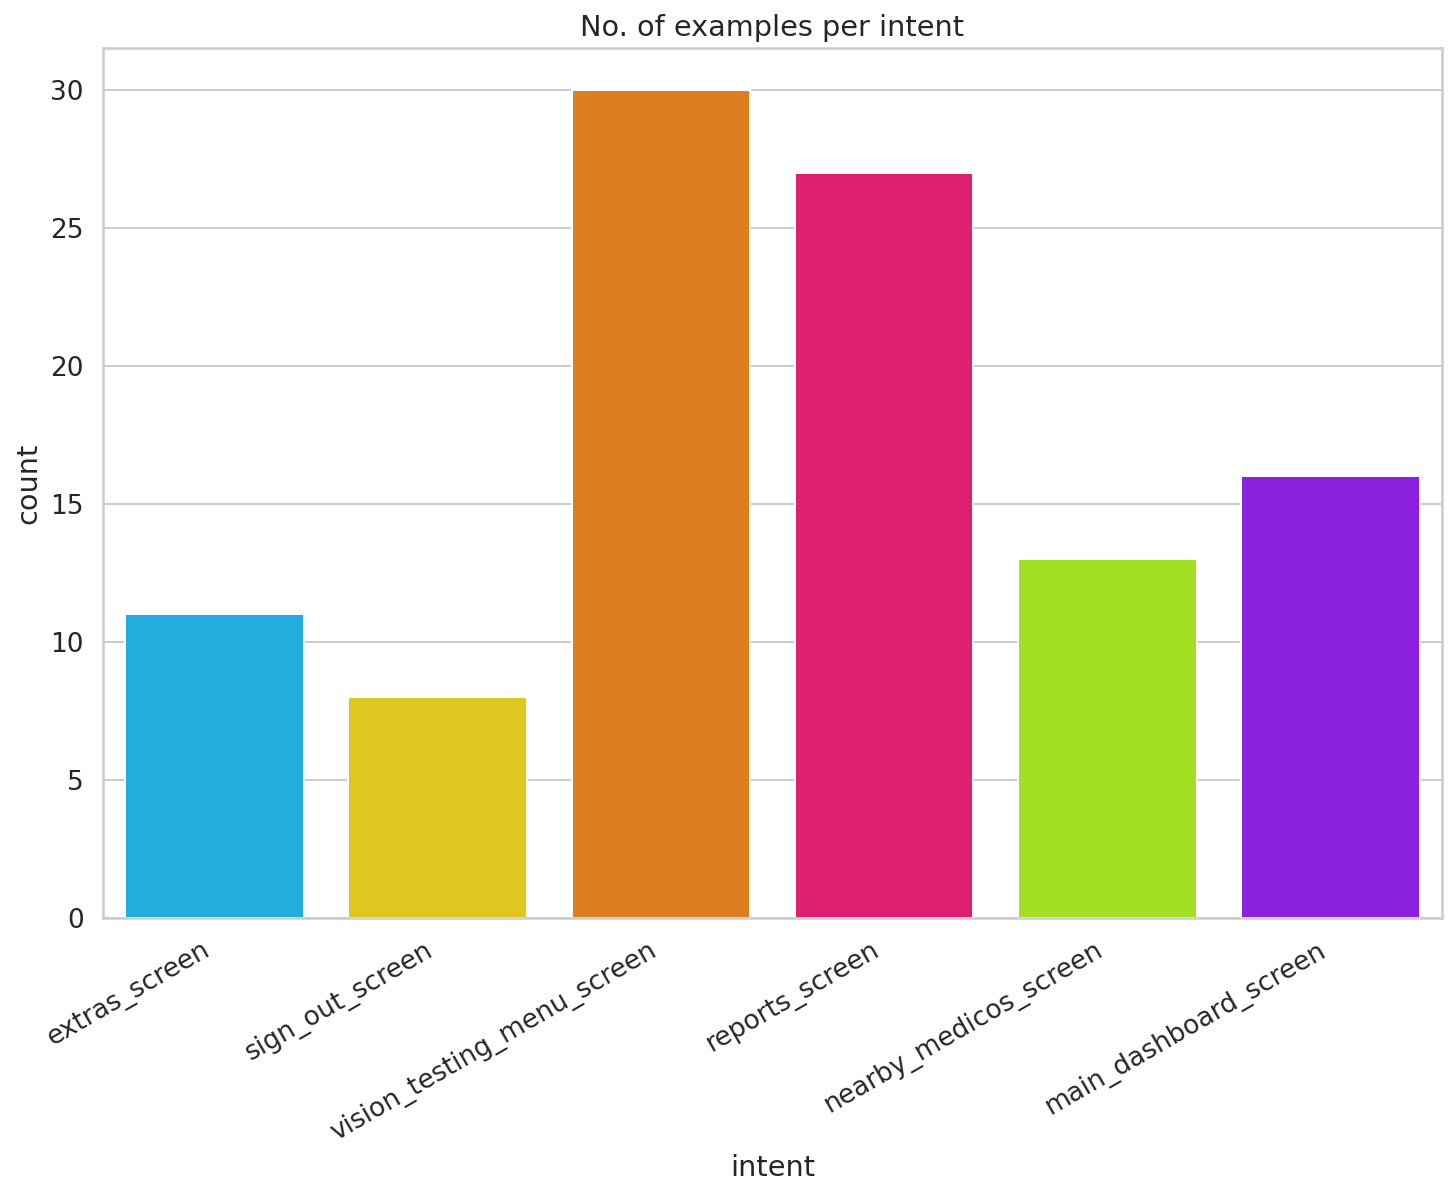

In [ ]:
chart =   sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title('No. of examples per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment = 'right');

# Bert Intent Recognition

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-09-02 15:58:49--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   205MB/s    in 3.1s    

2020-09-02 15:58:53 (205 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [ ]:
!unzip multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs('model', exist_ok=True)

In [ ]:
!mv multi_cased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name = 'multi_cased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join('model/', bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file =os.path.join(bert_ckpt_dir, 'bert_config.json')

#Pre Processing

In [ ]:
class intentRecogntion:
  TEXT = 'text'
  LABEL = 'intent'

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[intentRecogntion.TEXT], row[intentRecogntion.LABEL]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))
    
    np.array(y)
    y =tf.keras.utils.to_categorical(y)
    return np.array(x), y
  def _pad(self, ids):

    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(ids, 
                                                                  maxlen = 40,
                                                                  truncating='post',
                                                                  padding='post')

    return padded_inputs

In [ ]:

tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'), do_lower_case= False)

In [ ]:
#tokens = tokenizer.tokenize('Lets go to Japan')
#print(tokens)

In [ ]:
#tokenizer.convert_tokens_to_ids(tokens)


In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
      #bert.apply_adapter_freeze()
      bert.embeddings_layer.trainable = False
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, 40))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [ ]:
classes = train.intent.unique().tolist()
print(classes)
print(classes)
data = intentRecogntion(train, test, tokenizer, classes, max_seq_len=40)
print(data.max_seq_len)
data.max_seq_len = 40
print(data.max_seq_len)

105it [00:00, 3611.21it/s]
4it [00:00, 2036.81it/s]

['extras_screen', 'sign_out_screen', 'vision_testing_menu_screen', 'reports_screen', 'nearby_medicos_screen', 'main_dashboard_screen']
['extras_screen', 'sign_out_screen', 'vision_testing_menu_screen', 'reports_screen', 'nearby_medicos_screen', 'main_dashboard_screen']
max seq_len 11
11
40


In [ ]:
model = create_model(data.max_seq_len,  bert_ckpt_file)

bert shape (None, 40, 768)
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd200c87eb8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
print(data.train_x[0])
print(data.train_x.shape)
print(data.train_y.shape)

[  101 43105 21305 10911 10114 19868 10107   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(105, 40)
(105, 6)


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 40, 768)           177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir) 

history = model.fit(
    data.train_x, 
    data.train_y,
    batch_size = 16,
    shuffle = True,
    epochs = 25,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
7/7 [==============================] - 1s 188ms/step - loss: 1.0863 - accuracy: 0.9619
Epoch 2/5
7/7 [==============================] - 1s 132ms/step - loss: 1.0784 - accuracy: 0.9714
Epoch 3/5
7/7 [==============================] - 1s 132ms/step - loss: 1.0924 - accuracy: 0.9619
Epoch 4/5
7/7 [==============================] - 1s 132ms/step - loss: 1.0794 - accuracy: 0.9714
Epoch 5/5
7/7 [==============================] - 1s 135ms/step - loss: 1.0757 - accuracy: 0.9714


In [ ]:
_, test_acc = model.evaluate(data.test_x, data.test_y)
print(test_acc)

ValueError: ignored

In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
#print(classification_report(data.test_y, y_pred, target_names=classes))

In [ ]:
sentences = [
             'i want my reports', 
             'Open Extras', 
             'Take me to Vision Testing',
             'I want to get my vision tested',
             'sign out',
             ' i want to log out of the app',
             'show me nearby doctors'
]

tokens = map(tokenizer.tokenize, sentences)
tokens = map(lambda tok: ['[CLS]'] + tok + ['[SEP]'], tokens)
token_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(token_ids, 
                                                              maxlen = 40,
                                                              truncating='post',
                                                              padding='post')

print(data.max_seq_len)

predictions = model.predict(padded_inputs).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

print(classes[predictions[0]])

#model.save("/content/model.py")


40
text: i want my reports 
intent: reports_screen

text: Open Extras 
intent: extras_screen

text: Take me to Vision Testing 
intent: vision_testing_menu_screen

text: I want to get my vision tested 
intent: vision_testing_menu_screen

text: sign out 
intent: sign_out_screen

text:  i want to log out of the app 
intent: sign_out_screen

text: show me nearby doctors 
intent: nearby_medicos_screen

reports_screen
Model 123


AttributeError: ignored

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();